# Language Modeling From Scratch - Part 2
In the previous article we made use of probability distribution to create a name generator, we also looked into using a simple neural network. We concluded the article with the obersvation that even though a simple neural network with a single character input and single layer didn't work better than the probilistic approach, it offers significant flexibility in terms of input dimensionality. 

The probability distribution approach increases exponentionally in complexity wrt to the input dimension, which is popularly referred to "curse-of-dimensionality". In this article we'll see how neural network offers us a respite from this situation when we increase the input dimensions.


## Training Data

First we'll create our training data. Instead of using a single character as input, we'll make use of tripelts to predict the next word. This approach will help the model learn more information from the input and in-turn make better predictions.

In [67]:
words = open('names.txt', 'r').read().splitlines()
character_list = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(character_list)} # Adding 1 to each index so that special character can be given index 0
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()} # Create reverse mapping as well
len(words), words[:10]

(32033,
 ['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'])

In [68]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In the snippet below, we can see how the input triplets and their next character are arranged as training data(X and Y)

In [69]:
# Create training dataset in the form of Xs and Ys
number_of_previous_chars = 3
Xs, Ys = [], []
for word in words[:5]:
    out = [0] * number_of_previous_chars
    for ch in word + '.':
        idx = stoi[ch]
        xStr = "".join([itos[item] for item in out])
        print(f"X: {xStr} Y: {ch}")
        Xs.append(out)
        Ys.append(idx)
        out = out[1:] + [idx]

Xs = torch.tensor(Xs)
Ys = torch.tensor(Ys)
Xs.shape, Ys.shape

X: ... Y: e
X: ..e Y: m
X: .em Y: m
X: emm Y: a
X: mma Y: .
X: ... Y: o
X: ..o Y: l
X: .ol Y: i
X: oli Y: v
X: liv Y: i
X: ivi Y: a
X: via Y: .
X: ... Y: a
X: ..a Y: v
X: .av Y: a
X: ava Y: .
X: ... Y: i
X: ..i Y: s
X: .is Y: a
X: isa Y: b
X: sab Y: e
X: abe Y: l
X: bel Y: l
X: ell Y: a
X: lla Y: .
X: ... Y: s
X: ..s Y: o
X: .so Y: p
X: sop Y: h
X: oph Y: i
X: phi Y: a
X: hia Y: .


(torch.Size([32, 3]), torch.Size([32]))

As we did in the previous article, we can't use character index for traning. So we'll convert each character into its one_hot_encoding vector. Since we have 27 characters (26 + '.'), each character would be represented by a vector (1,27)


In [70]:
xEnc = F.one_hot(Xs, num_classes=27).float()
xEnc.shape

torch.Size([32, 3, 27])

After we have a character represented as (1,27) tensor, we'd like to embed the character into a lower dimensionality space, for this article we can make use of a 2D space as that would be easy to plot and visualize. We'll create an Embedding matrix that would then be used to generate Embedded input

In [72]:
Embedding = torch.randn((27, 2))
Embedding.shape

torch.Size([27, 2])

In [73]:
xEmb = xEnc @ Embedding
xEmb.shape

torch.Size([32, 3, 2])

Each character is now represented by (1,2) dimensional tensor

In [74]:
xEmb[0]

tensor([[-1.1452,  1.1325],
        [-1.1452,  1.1325],
        [-1.1452,  1.1325]])

## Neural Network
![https://cs231n.github.io/assets/nn1/neural_net2.jpeg](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

We'll implement a neural network similar to what's shown in the image above. We'll have two hidden layer, one input layer and one output layer. The xEmb would be the output of input layer and input of hidden layer 1. As we know each layer in neural network has associated Weights and Biases, we need W1, W2 and b1, b2 for each layer.

### Hidden Layer 1

Input for hidden layer 1 is xEmb of shape (, 3, 2), thus the input to hidden layer 1 would be of dimension (, 6) as each training sample has 3 character and each of the character is of shape (1,2) embedding. So we'll define the hidden layer weights as follows

In [75]:
W1 = torch.randn((6, 100))
b1 = torch.randn((100))

If we try to take dot product of W1 and xEmb right now, we'll get the following error

In [76]:
xEmb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

This is because shape of xEmb(32, 3, 2) is not compatible with W1 (6, 100) for dot product. Now we'll make use of pytorch concept called view, by specifying on dimension as the desired value and -1 for the remaining, pytorch automatically figures out the dimension mentioned as -1

In [77]:
xEmb.shape, xEmb.view(-1, 6).shape

(torch.Size([32, 3, 2]), torch.Size([32, 6]))

Now the matrices are compatible for dot product and we can make use of the neural network equation to get the output of hidden layer 1

In [78]:
h1 = xEmb.view(-1, 6) @ W1 + b1
h1.shape

torch.Size([32, 100])

### Hidden Layer 2
Similar to hidden layer 1, we'll initialize W2 and b2. Input to HL2 would be the output of HL1, i.e h1. Output of the last hidden layer is termed as logits (log-counts as we discussed in previous article)

In [79]:
W2 = torch.randn((100, 27))
b2 = torch.randn((27))

In [80]:
logits = h1 @ W2 + b2
logits.shape

torch.Size([32, 27])

To convert log-counts or logits to actual counts we'll perform `exp` operation and then normalize along column the counts to get probability of the each character in the output.

In [81]:
count = logits.exp()
probs = count / count.sum(1, keepdim=True)
probs.shape

torch.Size([32, 27])

To verify that the above operation was correct we can check that the sum along column for a row should be 0

In [82]:
probs[0].sum()

tensor(1.)

#### Cross Entropy Loss
In the previous article after getting the probabilities we were getting the probability of the expected character from output. To obtain a continuous smooth distribution we then took log of the probability and calculted sum of those log. In ideal situation, the probability of expected character should be 1, resultant log should be 0 and sum of logs of probabilities should 0 as well. So we use the sum of log of probabilies as our loss function. Since lower probability would result in lower log, we take negative of the log and term it as negative log likelihood. This is also called cross entropy loss.

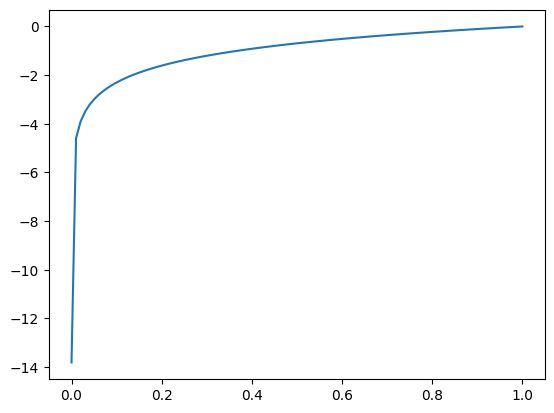

In [83]:
import numpy as np
x = np.linspace(0.000001, 1, 100)
y = np.log(x)
plt.plot(x, y, label='y = log(x)')

One disadvantage of implementing this method as is, is that for very low probability log approaches -inf, resulting in loss to be infinity. This is cosidered weird and generally disliked in the community, so intead we use pytorch implementation of cross_entropy. Pytorch adds a constant to each probability which prevents it from getting very low, hence smoothening out the log and trapping the log function, keeping it from going to inf

In [84]:
loss = F.cross_entropy(logits, Ys)
loss

tensor(51.4781)

## Using the entire dataset

In [85]:
# Training dataset
number_of_previous_chars = 3
Xs, Ys = [], []
for word in words:
    out = [0] * number_of_previous_chars
    for ch in word + '.':
        idx = stoi[ch]
        xStr = "".join([itos[item] for item in out])
        Xs.append(out)
        Ys.append(idx)
        out = out[1:] + [idx]

Xs = torch.tensor(Xs)
Ys = torch.tensor(Ys)
Xs.shape, Ys.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [88]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
xEnc = F.one_hot(Xs, num_classes=len(character_list)+1).float()

embedding = torch.randn((len(character_list)+1, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) # (3*2, 100)
b1 = torch.randn(200, generator=g) 
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [embedding, W1, b1, W2, b2]

Setting each of parameters as 'requires_grad' so that pytorch uses those in back-propagation

In [89]:
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters)

11897

## Training

Setting a training loop for 200000 steps, learning rate of 0.1 which decided how big of an update to be done to the parameters. We also track the loss and steps to later plot how loss varies with steps. We also make use mini-batches of size 32 to speed up the training process.

In [90]:
lr = 0.1
lri = []
lossi = []
stepi = []
for i in range(400000):
    # Define one hot encoding, embedding and hidden layer
    miniBatchIds = torch.randint(0, Xs.shape[0], (32,)) # Using a minibatch of size 32
    xEmb = xEnc[miniBatchIds] @ embedding
    h = torch.tanh(xEmb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ys[miniBatchIds])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.167637825012207


The plot below has a thickness associated with it, that's because we are optimizing on mini-batches

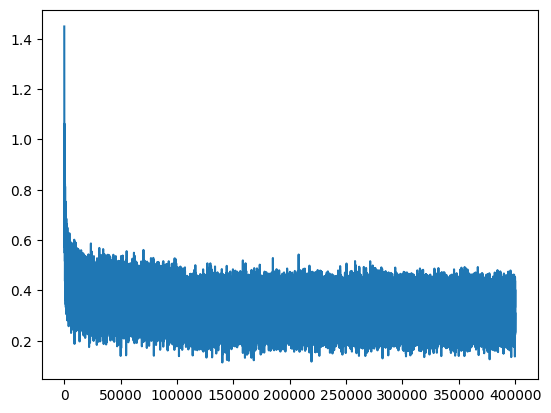

In [91]:
plt.plot(stepi, lossi)

We can also visualize the embedding we have created while training. 

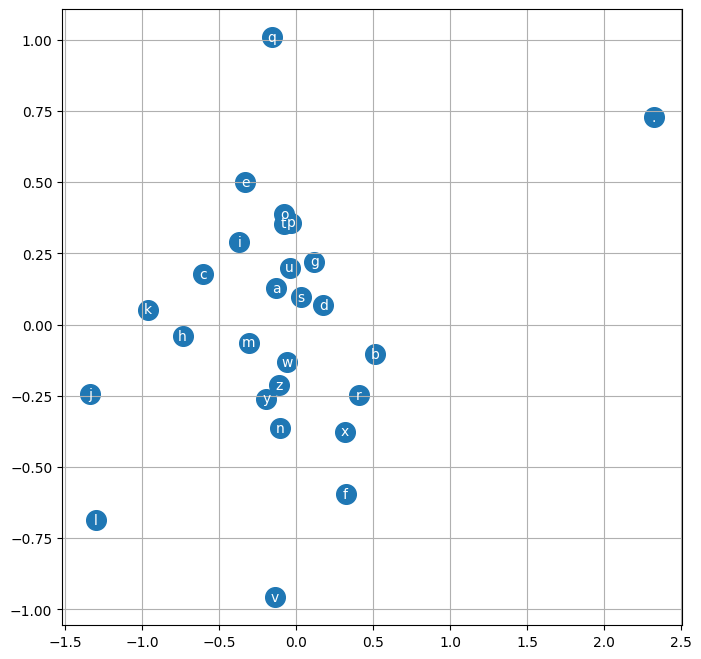

In [93]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0].data, embedding[:,1].data, s=200)
for i in range(embedding.shape[0]):
    plt.text(embedding[i,0].item(), embedding[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

## Inference
Let's try to generate 10 names using our model and compare them with the names generated using previous models

In [94]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * number_of_previous_chars # initialize with all ...
    while True:
      emb = embedding[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seen.
nihahalerethrushadra.
gradelynnelin.
shi.
jen.
eden.
van.
narahayziqhetalin.


## Conclusion

Names generated by the above models are more "name like" than the previous model as we have better information about the patterns. This can be attributed to 
- Better input provided to the model: Neural network is able to model relationship between multiple input characters and then predict the next character. As opposed to the probability distribution, neural network handles the "curse-of-dimensionality" better
- More complex model: Our current neural network is more complex than the one we discussed earlier and is able to learn better.